In [1]:
from seisLM.data_pipeline.foreshock_aftershock_dataset import (
  create_foreshock_aftershock_datasets
)
from seisLM.data_pipeline.foreshock_aftershock_dataloaders import (
  prepare_foreshock_aftershock_dataloaders)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 4
BATCH_SIZE = 8
EVENT_SPLIT_METHOD = 'temporal'
COMPONENT_ORDER = 'ZNE'
DIMENSION_ORDER = 'NCW'

# Examine the loader


In [3]:
loaders = prepare_foreshock_aftershock_dataloaders(
  num_classes=NUM_CLASSES,
  batch_size=BATCH_SIZE,
  event_split_method=EVENT_SPLIT_METHOD,
  component_order=COMPONENT_ORDER,
  standardize=True,
)

Seed set to 42
Seed set to 42


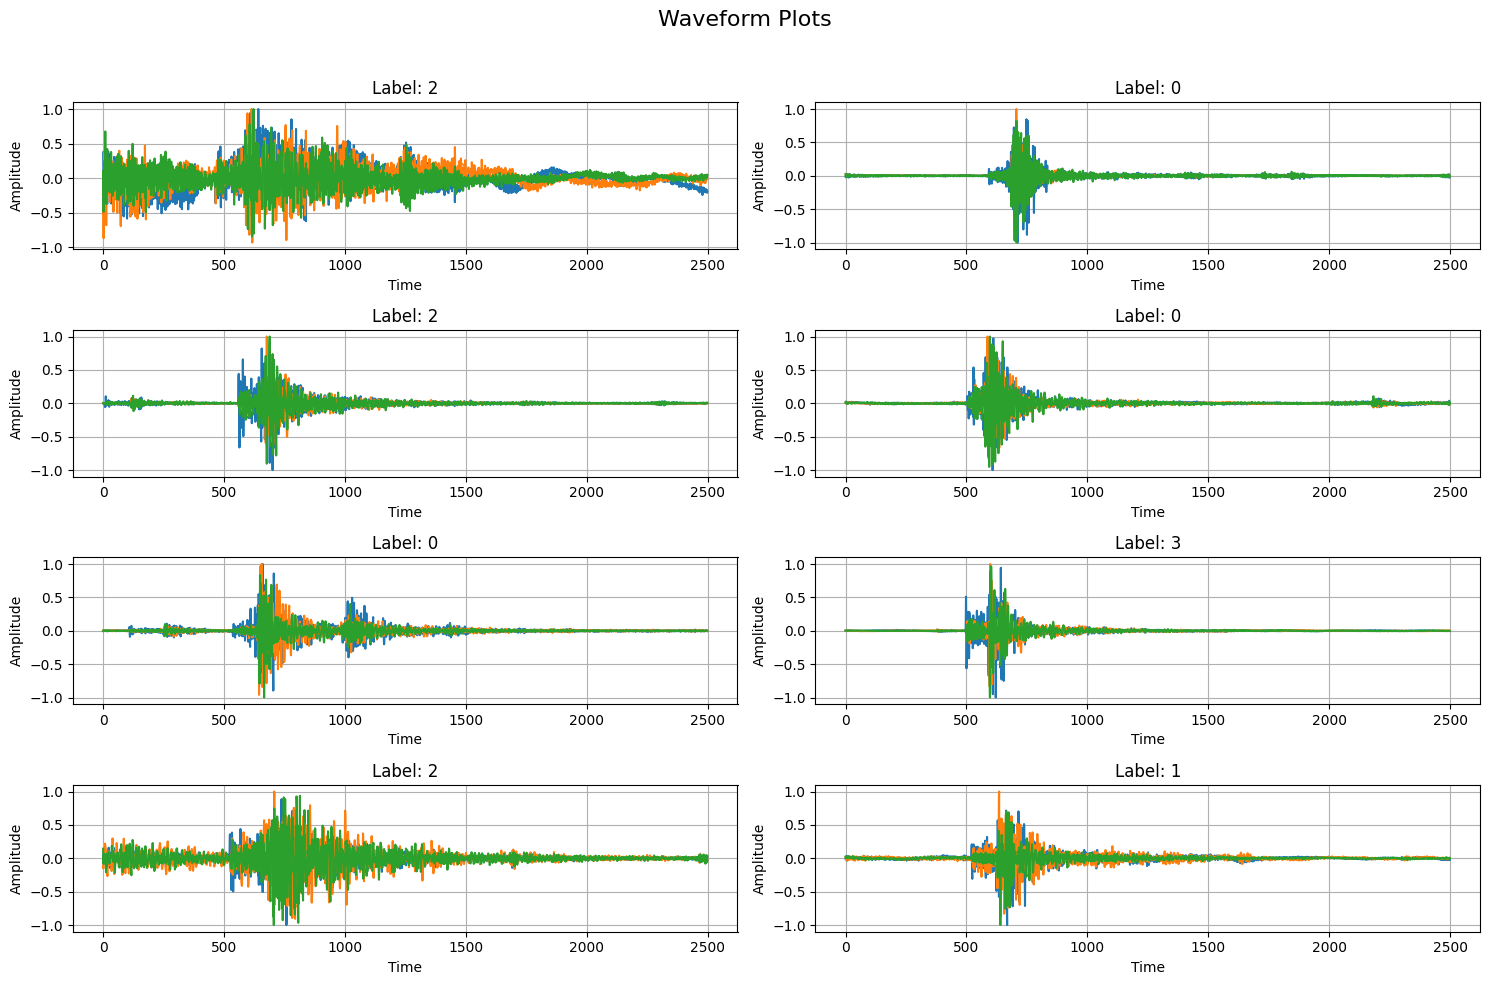

In [4]:
waveforms, labels = next(iter(loaders['train']))

# Create a figure with 8 subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 10))
fig.suptitle('Waveform Plots', fontsize=16)

# Plot each waveform in a separate subplot
for i in range(8):
    ax = axs[i // 2, i % 2]  # Compute subplot index
    ax.plot(waveforms[i].T)
    ax.set_title(f'Label: {labels[i].item()}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [5]:
import json
import ml_collections
import torch
from seisLM.model.task_specific.foreshock_aftershock_models import ShockClassifierLit #Wav2Vec2ForSequenceClassification

config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/foreshock_aftershock/seisLM_shock_classifier.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)

config.model_args.num_classes = NUM_CLASSES
config.model_args.use_weighted_layer_sum = True

model = ShockClassifierLit(
  model_name='Wav2Vec2ForSequenceClassification',
  model_config=config.model_args,
  # max_train_steps=1,
  training_config=config.trainer_args,
  ).model



X, y = next(iter(loaders['train']))
model(X)

tensor([[ 0.3688, -1.6390, -0.8961,  0.9322],
        [-1.4964, -0.4174, -0.3195, -0.8730],
        [ 0.1037,  0.0456,  0.1317,  0.4002],
        [-0.8293, -0.0978,  0.1264, -0.5901],
        [ 0.2486, -0.3758, -0.2273, -0.7692],
        [ 0.7890,  0.0257,  0.0600, -0.0864],
        [ 0.0681,  0.1940, -0.0092,  0.0795],
        [ 1.1441, -0.2154,  0.6309, -0.0567]], grad_fn=<AddmmBackward0>)

In [6]:
logits = model(X)
labels = y


loss = torch.nn.functional.cross_entropy(logits, labels)
predicted_labels = torch.argmax(logits, 1)



In [9]:
# for key, val in model.config.to_dict().items():
#   if 'dropout' in key:
#     print(key, val)

new_config = model.config
for key, value in new_config.to_dict().items():
  if 'dropout' in key:
    print(f'Orig. {key} value: {value}. New value: 0.1')
    value = 0.1
  setattr(new_config, key, value)


Orig. feat_extract_dropout value: 0.0. New value: 0.1
Orig. hidden_dropout_prob value: 0.0. New value: 0.1
Orig. hidden_dropout value: 0.0. New value: 0.1
Orig. attention_dropout value: 0.0. New value: 0.1
Orig. activation_dropout value: 0.0. New value: 0.1
Orig. feat_proj_dropout value: 0.0. New value: 0.1
Orig. final_dropout value: 0.0. New value: 0.1
Orig. feat_quantizer_dropout value: 0.0. New value: 0.1
Orig. classifier_dropout value: 0.9. New value: 0.1
Orig. seq_embed_dropout value: 0.9. New value: 0.1
Orig. timesteps_dropout value: 0.9. New value: 0.1


# examine the dataset directly


In [10]:
  datasets = create_foreshock_aftershock_datasets(
    num_classes=NUM_CLASSES,
    event_split_method=EVENT_SPLIT_METHOD,
    component_order=COMPONENT_ORDER,
    dimension_order=DIMENSION_ORDER,
    seed=42,
    # train_frac=train_frac,
    # val_frac=val_frac,
    # test_frac=test_frac,
  )


Seed set to 42
Seed set to 42


In [45]:
# datasets['train']['X'].shape# Number of classes
import numpy as np

# fold = 'test'
fold = 'train'
X = datasets[fold]['X']
y = datasets[fold]['y']

num_classes = len(np.unique(y))

# Initialize a dictionary to store categorized data
categorized_X = {i: datasets[fold]['X'][y == i] for i in range(num_classes)}
# categorized_time = {i: datasets['train']['occurence_time'][y == i] for i in range(num_classes)}
categorized_y = {i: datasets[fold]['y'][y == i] for i in range(num_classes)}
categorized_time = {i: np.array(datasets[fold]['occurence_time'])[y == i] for i in range(num_classes)}

time_order = {i : np.argsort(categorized_time[i]) for i in range(num_classes)}


In [49]:
np.sort(categorized_time[0])

array([Timestamp('2016-08-20 12:07:54'), Timestamp('2016-08-24 01:33:58'),
       Timestamp('2016-08-24 02:48:53'), ...,
       Timestamp('2016-09-19 00:08:41'), Timestamp('2016-09-19 01:10:26'),
       Timestamp('2016-09-19 02:44:11')], dtype=object)

In [55]:


list1 = categorized_time[0]
list2 = categorized_time[1]

dates_list1 = {ts.date() for ts in list1}
dates_list2 = {ts.date() for ts in list2}

# Find common dates
common_dates = dates_list1.intersection(dates_list2)

filtered_list1 = [ts for ts in list1 if ts.date() not in common_dates]
filtered_list2 = [ts for ts in list2 if ts.date() not in common_dates]



In [63]:
X.shape

(5072, 3, 2500)

In [64]:
y.shape

(5072,)

In [59]:
np.sort(filtered_list2)

array([Timestamp('2016-09-20 03:16:19'), Timestamp('2016-09-20 04:55:10'),
       Timestamp('2016-09-20 04:55:38'), ...,
       Timestamp('2016-10-26 14:08:45'), Timestamp('2016-10-26 14:39:47'),
       Timestamp('2016-10-26 14:49:12')], dtype=object)

In [60]:
len(filtered_list1)

1264

In [62]:
len(list2)

1268

In [37]:
categorized_X[0][time_order[0][-1], ...]

array([[-89.485435  , -11.43666   ,  35.612114  , ..., 211.30513   ,
        226.3539    , 242.40268   ],
       [-36.83257   , -20.84799   ,  -9.86341   , ..., 122.66212   ,
         55.646698  ,  35.631275  ],
       [ 46.482033  ,  86.45919   ,  64.43635   , ...,  35.440956  ,
          0.41811138,  36.395267  ]], dtype=float32)

In [36]:
time_order[0]

array([ 517,  849,  930, ...,  892,  831, 1258])

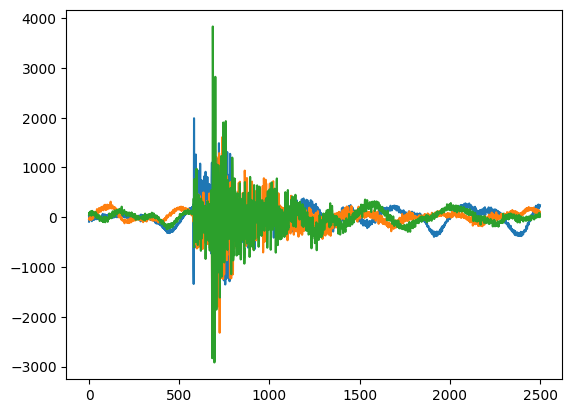

In [38]:
class_idx = 0
plt.plot(categorized_X[class_idx][time_order[class_idx][-1], ...].T)

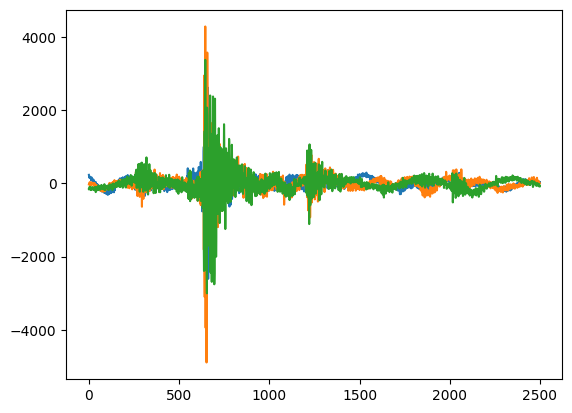

In [40]:
class_idx = 1
plt.plot(categorized_X[class_idx][time_order[class_idx][2], ...].T)

In [30]:
categorized_X[0].shape

(1268, 3, 2500)

In [20]:

np.sort(categorized_time[0])

array([Timestamp('2016-08-20 12:07:54'), Timestamp('2016-08-24 01:33:58'),
       Timestamp('2016-08-24 02:48:53'), ...,
       Timestamp('2016-09-19 00:08:41'), Timestamp('2016-09-19 01:10:26'),
       Timestamp('2016-09-19 02:44:11')], dtype=object)

In [21]:
np.sort(categorized_time[1])

array([Timestamp('2016-09-19 02:53:41'), Timestamp('2016-09-19 03:06:31'),
       Timestamp('2016-09-19 03:50:25'), ...,
       Timestamp('2016-10-26 14:08:45'), Timestamp('2016-10-26 14:39:47'),
       Timestamp('2016-10-26 14:49:12')], dtype=object)

In [15]:
# np.sort(categorized_time[2])



In [16]:
from torchinfo import summary

# model = ConvNet()
# batch_size = 16

# summary(model, input_size=(8, 3, 2500))
# summary(model, input_size=(batch_size, 1, 28, 28))

In [17]:
X.shape

(5072, 3, 2500)

In [18]:
1/8

0.125